In [1]:
!git clone https://github.com/vincentblot28/mapie_llm

Cloning into 'mapie_llm'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 36 (delta 11), reused 27 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.27 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
!pip install git+https://github.com/scikit-learn-contrib/MAPIE.git@v1


  Cloning https://github.com/scikit-learn-contrib/MAPIE.git (to revision v1) to /tmp/pip-req-build-6i886kh3
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/MAPIE.git /tmp/pip-req-build-6i886kh3
  Running command git checkout -b v1 --track origin/v1
  Switched to a new branch 'v1'
  Branch 'v1' set up to track remote branch 'v1' from 'origin'.
  Resolved https://github.com/scikit-learn-contrib/MAPIE.git to commit f627116933c3a60688d7b5e85757222b5cd92ecc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00
  Created wheel for MAPIE: filename=mapie-1.0.0a1-py3-none-any.whl size=187020 sha256=c5bdc47e85b0d7231dee51aeca3994eabe663834cfc38aed9df88f546aafdd27
  Stored in directory: /tmp/pip-ephem-wheel-cache-vmyjcthw/wheels/d1/0a/cb/49dc0b75bb1cf582ba37b2b4c099c6e423d3a58e028751a649
Succe

In [3]:
import json
import sys
sys.path.append('/content/mapie_llm')

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import torch
import torch.nn.functional as F
from mapie_v1.classification import SplitConformalClassifier
from mapie.metrics.classification import classification_coverage_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

from utils.prompt_utils import TransformCosmosQA

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
N_OBS = 1000
CONFIDENCE_LEVEL = 0.95

# Load data and transform it to X, y (X being a prompt)

In [6]:
data = json.load(open("/content/mapie_llm/cosmosqa_10k.json"))

In [7]:
data_transformer = TransformCosmosQA(data)
X, y = data_transformer.transform_data()

# Load the model and its tokenizer

In [ ]:
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
    model.eval()
    return tokenizer, model

# %%
tok, mo = load_model("mistralai/Mistral-7B-Instruct-v0.3")

# Wrap the model

In [10]:
class LLMClassifier:


    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.options = ["Answer: A", "Answer: B", "Answer: C", "Answer: D"]
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.option_ids = [self.tokenizer.encode(opt)[-1] for opt in self.options]
        self.is_fitted_ = True
        self.classes_ = [0, 1, 2, 3]

    def fit(self):
      pass


    def predict_proba(self, prompts):
        if isinstance(prompts, str):
            prompts = [prompts]  # Convert single prompt to list
        pred_probas = []
        for prompt in tqdm(prompts):
            prompt = [prompt]
            inputs = self._prepare_inputs(prompt)
            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs.logits[:, -1, :]  # Extract logits for the last token [batch_size, vocab_size]
            logits_options = logits[:, self.option_ids]  # Select logits corresponding to answer options

            probabilities = F.softmax(logits_options, dim=-1).cpu().numpy().flatten()
            probabilities /= probabilities.sum() # Ensure that the sum is exaclty equal to 1, which may not be true in some cases
            pred_probas.append(probabilities)
        return np.array(pred_probas)

    def predict(self, prompts):
        probas = self.predict_proba(prompts)
        return np.argmax(probas, axis=-1)

    def _prepare_inputs(self, prompts):
        inputs = self.tokenizer(prompts, return_tensors="pt", truncation=True)
        for k in inputs:
            if torch.is_tensor(inputs[k]):
                inputs[k] = inputs[k].to("cuda")
        return inputs

In [11]:
llm = LLMClassifier(tok, mo)

In [12]:
scc = SplitConformalClassifier(estimator=llm, confidence_level=CONFIDENCE_LEVEL)

In [13]:
X_small, y_small = X[:N_OBS], y[:N_OBS]

In [14]:
X_conf, X_test, y_conf, y_test = train_test_split(X_small, y_small, train_size=.5)

In [15]:
scc.conformalize(X_conf, y_conf)

100%|██████████| 500/500 [08:27<00:00,  1.01s/it]


In [16]:
y_pred, y_pred_set = scc.predict_set(X_test)

100%|██████████| 500/500 [08:28<00:00,  1.02s/it]


In [17]:
classification_coverage_score(y_test, y_pred_set[:, :, 0])

0.96

In [24]:
def print_examples_and_prediction_set(data_transformer, X, y, y_pred, y_pred_set):
  sizes = y_pred_set.sum(axis=1)
  unique_sizes= np.unique(sizes)

  for size in unique_sizes:
    all_idx_size = np.argwhere(sizes==size)[:, 0]
    random_idx = np.random.choice(all_idx_size, 1)[0]

    prompt_without_few_shot = X[random_idx].split("Answer:")[-2][3:]
    label = y[random_idx]
    pred = y_pred[random_idx]
    pred_set = np.argwhere(y_pred_set[random_idx][:, 0]).ravel()
    print("==========================================",
        prompt_without_few_shot,
        f"Correct answer: {data_transformer.label_encoder.inverse_transform([label])[0]}",
        f"Prediction: {data_transformer.label_encoder.inverse_transform([pred])[0]}",
        f"Prediction set: {data_transformer.label_encoder.inverse_transform(pred_set)}",
        sep="\n")

In [25]:
print_examples_and_prediction_set(data_transformer, X_test, y_test, y_pred, y_pred_set)

Context: Howard pulled out his wallet from his trousers and threw a fiver onto the bar , but the barman shook his head and mouthed ' Tenner ' . Howard was silently outraged at the price of a whiskey but consoled himself with the thought that he did n't go out often , so he may as well spend up big . The whiskey sour was sharp on his throat and he almost gagged at the smell , but after the second swallow , it was n't so bad . Howard saw a shadow sliding up towards him .
Question: What do we know about Howard ?
Choices:
A. Howard is a shadow .
B. Howard owes a fiver .
C. Howard is a drinker .
D. They have a financial interest in the subject .
E. I don't know
F. None of the above

Correct answer: C
Prediction: C
Prediction set: ['C']
Context: Norman from my class participated and did a stand - up comedy . A ' 3-in-1 ' act . As a girl , a boy and the music teacher , Ms Madonna . < select ... > < option ... > Haha Ha ha Ha - ha Aha Hahn Hana .
Question: What may be the purpose of this post 

In [20]:
accuracy = accuracy_score(y_test, y_pred)


In [21]:
print(f"The LMM is right {round(accuracy * 100, 2)} % of the time. \n")


The LMM is right 85.6 % of the time. 



In [51]:
def plot_label_distribution(y_pred_set):
    num_labels_per_sample = np.sum(y_pred_set, axis=1)
    label_counts = np.bincount(num_labels_per_sample)
    min_number = np.min(num_labels_per_sample)
    max_number = np.max(num_labels_per_sample)
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.hist(num_labels_per_sample, bins=range(min_number, max_number + 2), align='left', rwidth=0.8)
    plt.title('Distribution of the size of prediction sets')
    plt.xlabel('Size')
    plt.ylabel('Number of prediction sets')
    plt.xticks(range(min_number, max_number + 1))
    plt.show()


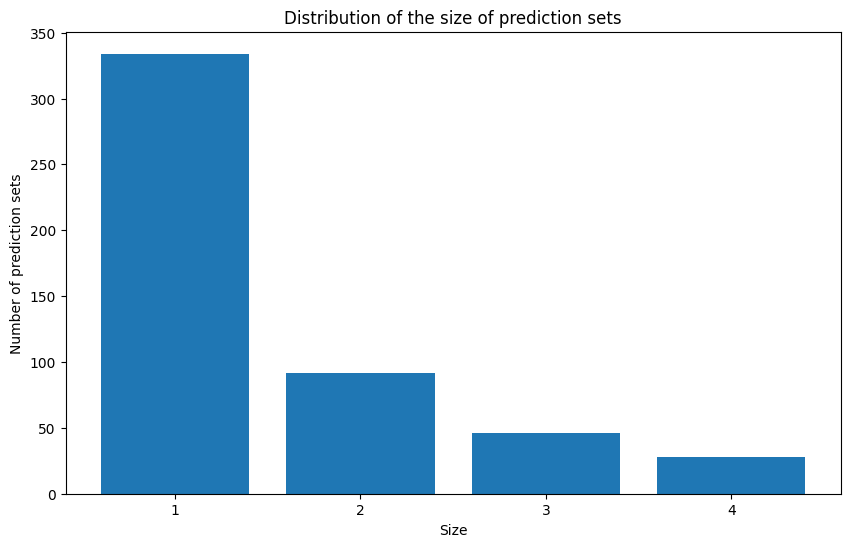

In [52]:
plot_label_distribution(y_pred_set[:, :, 0])

In [49]:
def plot_accuracy_per_size(y_test, y_pred_set):
    sizes = y_pred_set.sum(axis=1)
    unique_sizes = np.unique(sizes)
    accuracies = []
    for size in unique_sizes:
        # Indices where the prediction set size is equal to the current size
        indices = np.where(sizes == size)[0]
        # True labels and predictions for the current size
        true_labels = y_test[indices]
        predictions = y_pred[indices]
        # Accuracy calculation for the current size
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(unique_sizes.astype(int), accuracies)
    plt.title('Accuracy for each size of prediction sets')
    plt.xlabel('Size of Prediction Set')
    plt.ylabel('Accuracy')
    plt.xticks(unique_sizes.astype(int)) # set xticks to integers
    plt.show()


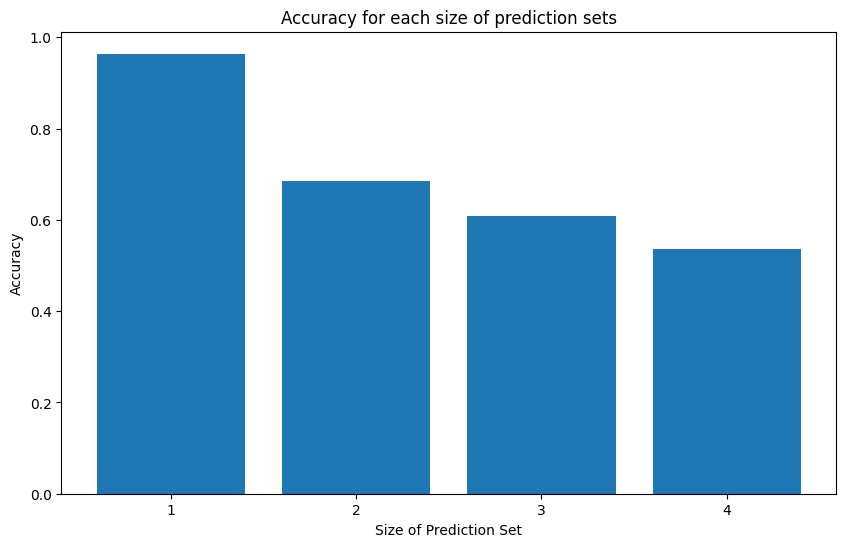

In [50]:
plot_accuracy_per_size(y_test, y_pred_set[:, :, 0])
